In [1]:
import graph_tool.all as gt
from math import sqrt

In [2]:
from random import *

In [3]:
from libs.community_detection.worker_selection import *
from libs.evaluation import *

In [4]:
csvGraphsPath="../graphs/csv/"
csvGraphFileName="facebook_combined.csv"
csvGraphFilePath=csvGraphsPath+csvGraphFileName
formatedGraphPath="../graphs/formatted/"
fbGraph=gt.load_graph_from_csv(csvGraphFilePath)

FileNotFoundError: [Errno 2] No such file or directory: '../graphs/csv/facebook_combined.csv'

In [5]:
import igraph as ig

In [6]:
F=ig.Graph.Read("../graphs/formatted/facebook_combined.csv",format="ncol").as_undirected()

In [7]:
nbWorkers=10

In [8]:
partition=findCommunities(F.community_multilevel)

In [9]:
workerAssignment=[sizeProRataWorkerAssignement,
                          sizeOrderedRoundRobinWorkerAssignement,
                          diameterProRataWorkerAssignement,
                          diameterWorkerAssignment,
                          #capacityBasedWorkerAssignment,
                          #subpartitioning
                         ]

In [10]:
def assignWorkers(partition,nWorkers,assignmentFunction,withBoundary):
    graph=partition.graph
    assert nWorkers>=0, "{} workers to assign: Number of workers to assign must be positive or zero".format(nWorkers)
    assert len(graph.vs)>=nWorkers, "{} workers to assign on {} nodes: Can't assign more workers than there are vertices".format(nWorkers,len(graph.vs))
    
    clusterGraph=partition.cluster_graph("first")

    for idx, cluster in enumerate(clusterGraph.vs):
        cluster["name"]="C{}".format(idx)

    workerIds=[]
    clusterIds=[]
    if len(partition)<nWorkers:        

        clusterGraph=assignmentFunction(partition, clusterGraph, nWorkers)
        clusterIds=range(len(partition))
    elif len(partition)==nWorkers:
        #1cluster/1worker
        for cluster in clusterGraph.vs:
            cluster["nb_workers"]=1
        clusterIds=range(len(partition))
    else:
        clusterIds=maxShortestPathNodesSelection(clusterGraph,nWorkers)
        for cluster in clusterGraph.vs:
            if cluster.index in clusterIds:
                cluster["nb_workers"]=1
            else:
                cluster["nb_workers"]=0
   
    #Etape2
    #for chaque cluster de workers
    #prendre son sous-graphe+ les noeuds frontaliers d'autres clusters, BFS des frontières et Etape1 nb_workers fois
    for clusterId in clusterIds:
        workerIds.extend(assignWorkersInCommunity(graph,clusterGraph,clusterId,withBoundary))

    assert len(workerIds)==nWorkers, "Assigned {} workers instead of {}".format(len(workerIds),nWorkers)
    return workerIds,clusterGraph,clusterIds

In [11]:
%time workerIds,clusterGraph,clusterIds=assignWorkers(partition,nbWorkers,workerAssignment[0],False)
print(workerIds)

CPU times: user 122 ms, sys: 38 µs, total: 122 ms
Wall time: 120 ms
['V945', 'V2655', 'V2767', 'V681', 'V3983', 'V692', 'V\ufeff0', 'V2659', 'V2650', 'V3059']


### What if we distantiated workers based on the whole graph (as if one unique community)

%time workerIds=F.vs[maxShortestPathNodesSelection(F,nbWorkers)]["name"]

### Arbitrary workers

In [ ]:
workerIds=['V2927', 'V2962', 'V1546', 'V2358', 'V1924', 'V1190', 'V2638', 'V3183', 'V4017', 'V2861', 'V1579', 'V609', 'V23', 'V3605', 'V3810', 'V3429', 'V3606', 'V2070', 'V1077', 'V2216', 'V189', 'V696', 'V2806', 'V182', 'V1878', 'V1109', 'V3435', 'V2700', 'V3997', 'V1764', 'V3486', 'V3953', 'V2444', 'V98', 'V2808', 'V1530', 'V256', 'V3033', 'V185', 'V588', 'V39', 'V1558', 'V2507', 'V1728', 'V1328', 'V181', 'V2701', 'V3660', 'V985', 'V3315', 'V399', 'V400', 'V1410', 'V126', 'V1444', 'V667', 'V2672', 'V2368', 'V197', 'V3974', 'V1586', 'V3424', 'V1726', 'V1066', 'V1561', 'V3054', 'V2582', 'V3897', 'V3386', 'V1114', 'V593', 'V447', 'V1182', 'V2760', 'V2654', 'V2033', 'V683', 'V878', 'V281', 'V2052', 'V2804', 'V840', 'V2130', 'V1469', 'V2148', 'V3745', 'V3093', 'V4004', 'V431', 'V572', 'V3539', 'V935', 'V3970', 'V2704', 'V3996', 'V762', 'V1349', 'V1927', 'V454', 'V3643']

## Plot

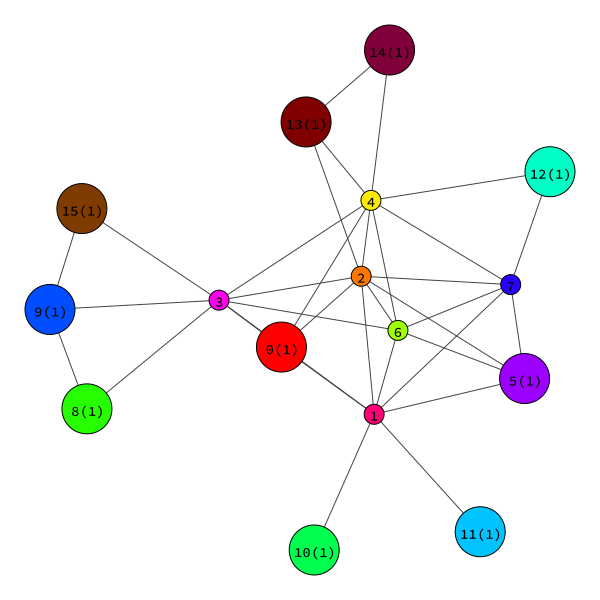

In [12]:
for idx, cluster in enumerate(clusterGraph.vs):
    if cluster.index in clusterIds:
        cluster["size"]=50
        cluster["label"]="{}({})".format(idx,cluster["nb_workers"])
    else:
        cluster["size"]=20
        cluster["label"]="{}".format(idx)
    cluster["color"]=partition.subgraph(idx).vs[0]["color"]
    cluster["shape"]="circle"
    
ig.plot(clusterGraph,"clusterGraph.png",margin=(50,50,50,50))

In [13]:
print(len(clusterGraph.vs))

16


In [14]:
for v in F.vs:
    if v["name"] in workerIds:
        v["size"]=25
        v["shape"]="triangle"
    else:
        v["size"]=1
        v["shape"]="circle"

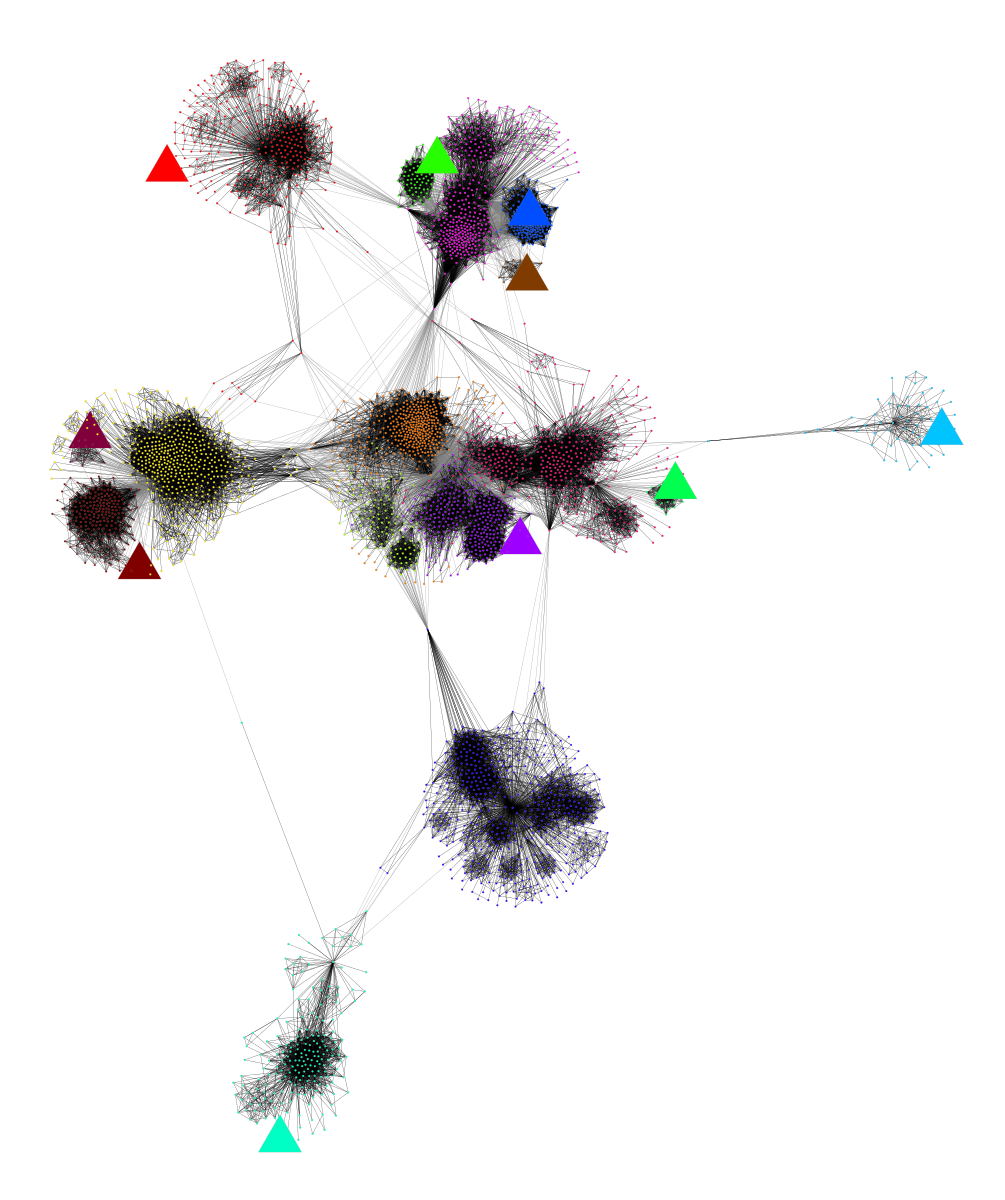

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f50ef911b80, at 0x7f50ef908be0>

In [15]:
G=F.to_graph_tool(vertex_attributes={"color":"vector<float>","size":"int","shape":"string"},edge_attributes={"color":"vector<float>"})
gt.graph_draw(G, vertex_fill_color=G.vertex_properties["color"],vertex_shape=G.vertex_properties["shape"],vertex_size=G.vertex_properties["size"],edge_color=G.edge_properties["color"])

## Evaluate

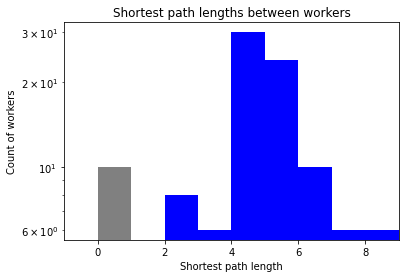

In [16]:
import numpy as np
from matplotlib import pyplot as plt
import math
data=list(graphDistances(F,workerIds))
data=[[d if d!=math.inf else -1 for d in l] for l in data]
maxDist=max([max(l,default=0) for l in data],default=0)
colors=["grey","red","blue"]
labels=["self","same community","other community"]
# fixed bin size
bins = np.arange(-1, 100, 1) # fixed bin size

plt.xlim([-1, maxDist+1])
plt.yscale("log")
plt.hist(data, bins=bins, color=colors, label=labels, stacked=True)
plt.title('Shortest path lengths between workers')
plt.xlabel('Shortest path length')
plt.ylabel('Count of workers')

plt.show()

In [17]:
#the greater the value, the better
print(sum([sum(l) for l in data]))

424


### Intra cluster distances

In [18]:
import numpy as np
from matplotlib import pyplot as plt

nbClusters=len(partition.subgraphs())
nbCol=4
fig,ax = plt.subplots(nrows = (nbClusters+nbCol)//nbCol, ncols = nbCol,sharex=True, sharey=True,figsize=(nbCol*4,3*nbClusters//nbCol))

for idx, subgraph in enumerate(partition.subgraphs()):
    inClusterWorkers=[w for w in workerIds if w in subgraph.vs["name"]]
    data=list(graphDistances(F,inClusterWorkers,workerIds,subgraph.vs[0]["cluster"]))
    colors=["grey","red","blue"]
    labels=["self","same community","other community"]

    # fixed bin size
    bins = np.arange(0, maxDist+1, 1) # fixed bin size

    ax[idx//nbCol][idx%nbCol].hist(data, bins=bins, color=colors, label=labels, stacked=True)
    ax[idx//nbCol][idx%nbCol].title.set_text('SPLs from {} worker{} in cluster {}'.format(len(inClusterWorkers),"s" if len(inClusterWorkers)>1 else "",idx))
fig.xlim=[0, maxDist+1]
fig.yscale="log"
fig.suptitle='Shortest path lengths between workers'
fig.xlabel='Shortest path length'
fig.ylabel='Count of workers'
#fig.savefig(imgPath)
plt.close(fig)

## Graph Metrics

### Max distance between nodes (graph diameter)

In [ ]:
print(F.diameter())

### Distances inter-nodes intra-clusters (cluster diameters)

In [ ]:
subgraphs=partition.subgraphs()
diameters=list([subgraph.diameter() for subgraph in subgraphs])
plt.plot(diameters)

In [ ]:
radii=list([subgraph.radius() for subgraph in subgraphs])
plt.plot(radii)

### Nodes per community

In [ ]:
from collections import Counter
nbClusters=len(Counter(F.vs["cluster"]))

In [ ]:
bins = np.arange(0, nbClusters+1, 1)
plt.hist(F.vs["cluster"], bins=bins)
plt.title('Number of nodes in communities')
plt.xlabel('Community')
plt.ylabel('Count of nodes')

plt.show()

### Workers per cluster

In [ ]:
data=[F.vs.find(worker)["cluster"] for worker in workerIds]
bins = np.arange(0, nbClusters+1, 1)
plt.hist(data, bins=bins)
plt.title('Number of workers in communities')
plt.xlabel('Community')
plt.ylabel('Count of workers')

ax = plt.gca()
p = ax.patches
heights = [int(patch.get_height()) for patch in p]
print(heights)

#plt.show()

### Cluster diameter based worker count

In [ ]:
diameters=[subgraph.diameter() for subgraph in partition.subgraphs()]

workers=[diameter//2+diameter%2 for diameter in diameters]
assignedWorkers=sum(workers)
print(assignedWorkers)

In [ ]:
def closenessdCliques(graph, minDist, nodesSubset=None):
    nodes=graph.vs
    candidates=set()
    if nodesSubset is None:
        matPCC=graph.shortest_paths_dijkstra()
        nodesSubset=nodes["name"]
    else:
        nodesIdx=[graph.vs.find(n).index for n in nodesSubset]
        matPCC=graph.shortest_paths_dijkstra(nodesIdx,nodesIdx)
        print(np.size(matPCC))
    dfPCC=pd.DataFrame(matPCC,nodesSubset,nodesSubset)
    #print((dfPCC > minDist).values)
    restrictDf=(dfPCC.where((dfPCC <= minDist) & (dfPCC > 0))).values.tolist()
    g = ig.Graph.Adjacency(restrictDf).as_undirected()
    g.vs["name"]=nodesSubset
    #ig.plot(g,"../graphs/img/graph.png")
    #print(len(g.vs))
    try:
        cliques=g.largest_cliques()
        candidates=[[nodesSubset[idx] for idx in clique] for clique in cliques]
        
        print("n_clq",len(cliques),"l_clq", len(cliques[0]),"a clq", cliques[0])
        print("len(c)",len(candidates[0]),"len(n)",len(nodesSubset))
        yield candidates
    except TimeoutException:
        print("Timeout")
        candidates=None
    return candidates

In [ ]:
list(closenessCliques(F,2,workerIds))

In [ ]:
graph.get_shortest_paths

In [ ]:
d=8
minDist=lambda d:range(4,d+1)
minDist(d)

In [ ]:
import progressbar
import time
import progressbar

with progressbar.ProgressBar(max_value=10) as bar:
    for i in range(10):
        time.sleep(0.1)
        bar.update(i)
        

In [ ]:
import numpy as np
import math
np.logspace(1, math.log10(4000//5), 10, endpoint=True,dtype=int)

fg=closenessCliques(F, 1, nodesSubset=None, imgPath=None)

In [25]:
print(len(fg[0]),len(fg))

69 43616


import json
with open("maxCliquesWholeGraph.json","w") as f:
    json.dump(fg,f)